# 🌹 Exploration 6. 캐글 Leaderboard 정복하기 🌹

## 😎 프로젝트 목표 😎
1. 캐글에 submission을 하기 위한 데이터 분석의 과정들을 성공적으로 진행한다.
2. 제출하는 노트북이 캐글의 실제 커널로 사용될 수 있도록 체계화할 수 있다.
3. 최적화 기법을 활용하여 캐글 리더보드의 Private Score 값이 11만 이하가 되도록 할 수 있다.

### ✨ 필요한 Module 및 Library 설치하기 ✨

In [1]:
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### ✨ 데이터 불러오기 ✨

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
print('훈련 데이터의 차원 : {}'.format(train.shape))
print('테스트 데이터의 차원 : {}'.format(test.shape))

훈련 데이터의 차원 : (15035, 21)
테스트 데이터의 차원 : (6468, 20)


### ✨ 훈련/테스트 데이터 살펴보기 ✨

#### 참고사항
- 집의 가격은 주거 공간의 면적, 위치, 경관, 건물의 연식 등 여러 가지 복잡한 요인의 조합에 의해 결정된다.
- 어떤 조건을 가진 집의 가격이 높은지를 예측하는 모델을 만드는 회귀 문제임을 상기한다.

#### 특성 알아보기
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
# 훈련 데이터 앞 7개만 살펴보자.
train.head(7)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000


In [5]:
# 테스트 데이터 앞 7개만 살펴보자.
test.head(7)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
5,15040,20140703T000000,5,2.50,2270,6300,2.0,0,0,3,8,2270,0,1995,0,98092,47.3266,-122.169,2240,7005
6,15041,20140624T000000,3,1.75,1520,6380,1.0,0,0,3,7,790,730,1948,0,98115,47.6950,-122.304,1520,6235


### ✨ 데이터 전처리 ✨

#### date column 정수(int)화 하기
- 원본 train, test 데이터의 date라는 특성에는 문자열 'T'가 포함되어 있다.
- 따라서 모델이 날짜 데이터를 예측을 위한 특성으로 쓸 수 있도록 정수화하는 작업을 거친다.

In [6]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head(7)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,201504,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,201405,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000


In [7]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head(7)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
5,15040,201407,5,2.50,2270,6300,2.0,0,0,3,8,2270,0,1995,0,98092,47.3266,-122.169,2240,7005
6,15041,201406,3,1.75,1520,6380,1.0,0,0,3,7,790,730,1948,0,98115,47.6950,-122.304,1520,6235


#### id column 삭제하기
- 원본 train, test 데이터의 id라는 특성은 단순히 데이터를 구분하기 위해 번호를 매긴 것이다.
- 따라서 집의 가격을 예측하는 특성으로서는 적합하지 않다고 보고, 해당 column을 삭제 처리한다.

In [8]:
del train['id']

# id column이 잘 삭제되었는지 확인하기
print(train.columns)
# id column 삭제 후 다시 데이터 프레임 출력하기
train.head()

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [9]:
del test['id']

# id column이 잘 삭제되었는지 확인하기
print(test.columns)
# id column 삭제 후 다시 데이터 프레임 출력하기
test.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


#### train의 price 데이터의 분포 확인하기
- 시각화 라이브러리 seaborn의 kdeplot을 이용해서 price 데이터의 분포를 확인한다.

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64


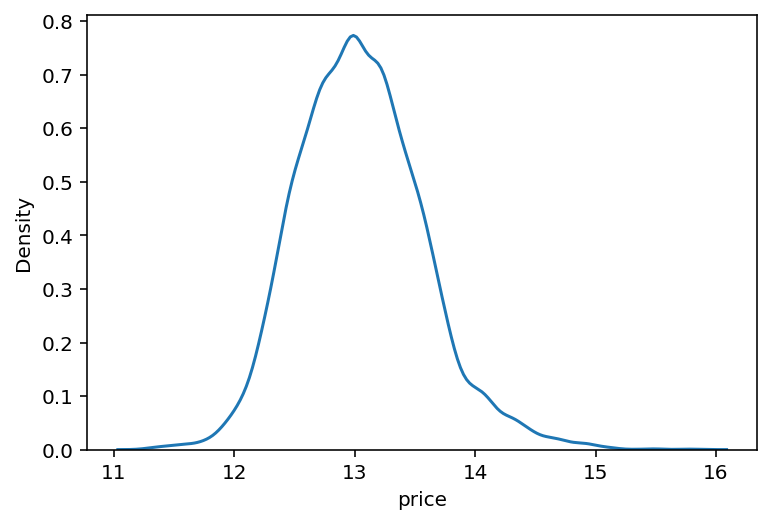

In [10]:
train['price'] = np.log1p(train['price'])
print(train['price'])

sns.kdeplot(train['price'])
plt.show()

#### 훈련 데이터의 price column 삭제하기
- 훈련 데이터의 price라는 특성을 다른 변수인 y에 저장하고 훈련 데이터셋에서 삭제한다.

In [12]:
y = train['price']
del train['price']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### 타겟 데이터 확인하기

In [13]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

#### 타겟 데이터의 분포 확인하기

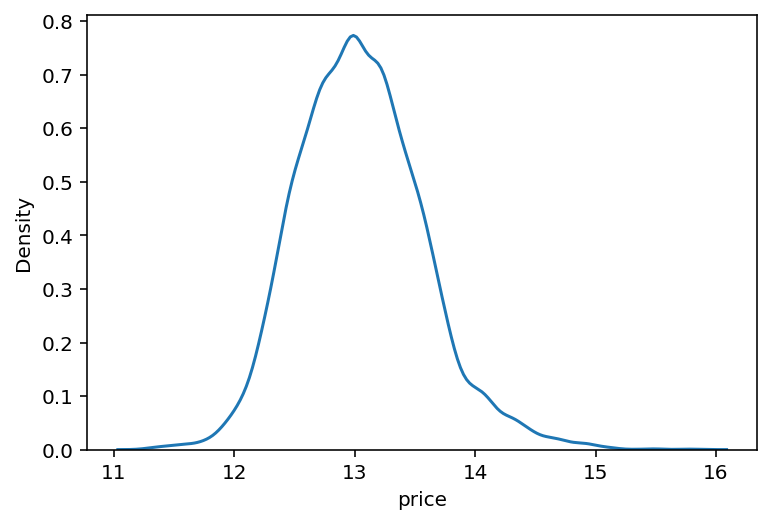

In [14]:
sns.kdeplot(y)
plt.show()

#### 타겟 데이터 정규화
- 이 문제는 집의 가격을 예측하는 **회귀 문제**이므로, 이미지 분류나 처리 문제와는 달리 정규화 과정이 중요하다.
- **np.log1p() 함수를 이용해서 로그 변환**을 취하고, 나중에 모델이 가격을 예측한 후에 **다시 np.expm1()을 활용해서 원상으로 되돌린다.**

In [15]:
y = np.log1p(y)
y

0        2.588515
1        2.572667
2        2.649161
3        2.599632
4        2.608893
           ...   
15030    2.661820
15031    2.696179
15032    2.624224
15033    2.631833
15034    2.616781
Name: price, Length: 15035, dtype: float64

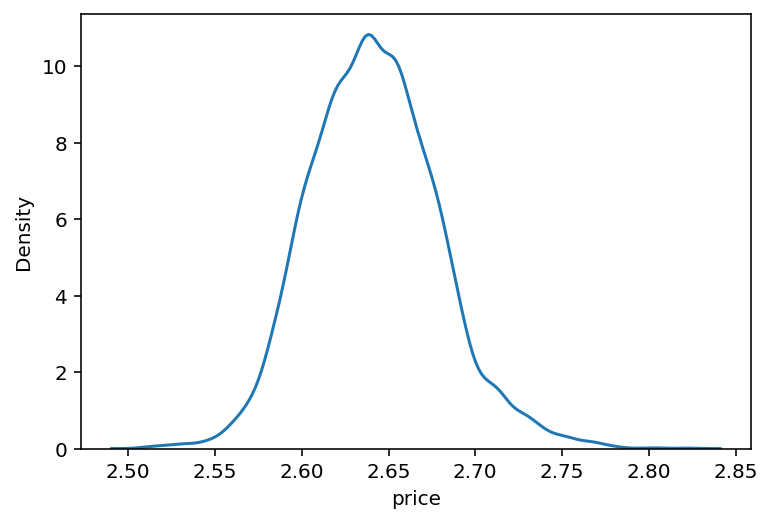

In [16]:
sns.kdeplot(y)
plt.show()

#### 훈련 데이터 자료형 확인하기

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

#### ✨ 한쪽으로 치우친 데이터 확인 및 정규화 가이드! ✨
- 우선, 다시 한번 train 데이터와 test 데이터를 살펴본 다음 한쪽으로 치우친 데이터를 확인해 본다.
- 이 과정을 통해 한쪽으로 치우친 데이터를 정규화하는 작업이 이루어진다.

#### train, test 데이터 다시 확인하기
- 아래의 train, test 데이터의 수치 흐름을 분석하고 한 쪽으로 치우친 분포를 가진 특성을 확인하고자 한다.

In [23]:
train.head(100)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,201412,4,2.50,3670,315374,2.0,0,0,4,9,3670,0,1994,0,98077,47.7421,-122.026,2840,87991
96,201408,3,2.00,1360,3090,2.0,0,0,3,8,1360,0,1990,0,98103,47.6838,-122.353,1500,3090
97,201504,3,1.00,1110,5000,1.5,0,0,3,7,1110,0,1947,0,98107,47.6550,-122.359,1420,5000
98,201504,4,3.25,5180,19850,2.0,0,3,3,12,3540,1640,2006,0,98006,47.5620,-122.162,3160,9750


In [24]:
test.head(100)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,201502,3,1.75,1510,10248,1.0,0,0,3,7,1510,0,1969,0,98023,47.2929,-122.371,1510,9753
96,201409,2,1.00,1240,12092,1.0,0,0,3,6,960,280,1922,1984,98146,47.4957,-122.352,1820,7460
97,201410,3,2.50,3030,45004,2.0,0,0,3,9,3030,0,1987,0,98077,47.7721,-122.093,3080,35781
98,201409,4,3.50,2800,6750,2.0,0,0,3,9,1890,910,1951,2002,98105,47.6690,-122.275,2370,6120


#### 찾아낸 특성에 대한 분포 확인하고 정규화하기
- A. sqft_living
- B. sqft_lot
- C. sqft_above
- D. sqft_basement
- E. sqft_living15
- F. sqft_lot15

## A. sqft_living

0        7.074117
1        6.647688
2        7.427144
3        7.447751
4        6.966967
           ...   
15030    7.832411
15031    8.163656
15032    7.333676
15033    7.745436
15034    6.928538
Name: sqft_living, Length: 15035, dtype: float64


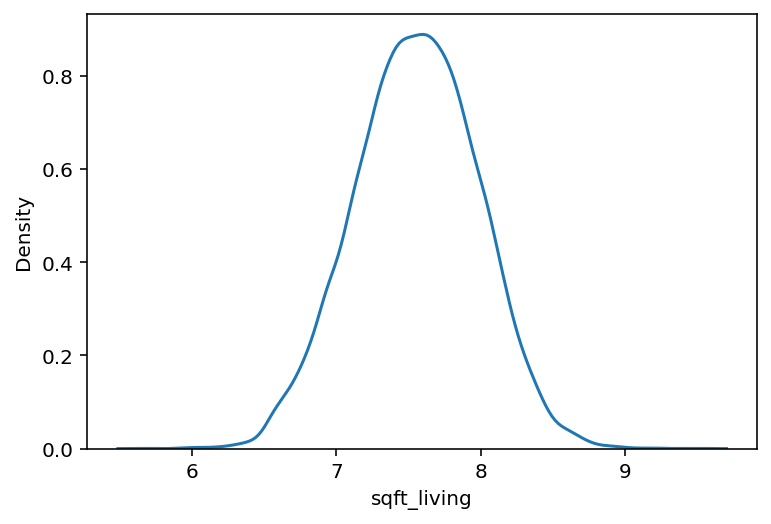

In [25]:
train['sqft_living'] = np.log1p(train['sqft_living'])
print(train['sqft_living'])

sns.kdeplot(train['sqft_living'])
plt.show()

0       7.852050
1       7.581210
2       8.598036
3       7.484930
4       7.544861
          ...   
6463    7.313887
6464    7.307202
6465    7.178545
6466    6.928538
6467    7.378384
Name: sqft_living, Length: 6468, dtype: float64


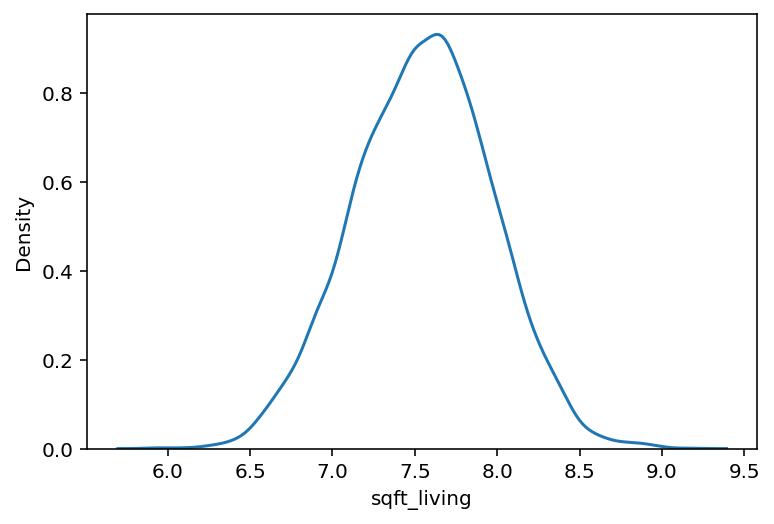

In [26]:
test['sqft_living'] = np.log1p(test['sqft_living'])
print(test['sqft_living'])

sns.kdeplot(test['sqft_living'])
plt.show()

## B. sqft_lot

0        8.639588
1        9.210440
2        8.997271
3        8.827615
4        9.181118
           ...   
15030    8.703507
15031    8.881975
15032    7.031741
15033    8.668024
15034    6.981935
Name: sqft_lot, Length: 15035, dtype: float64


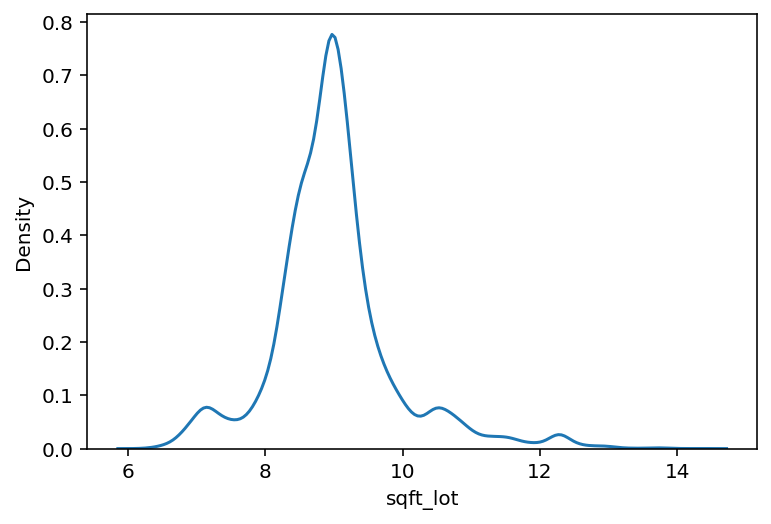

In [27]:
train['sqft_lot'] = np.log1p(train['sqft_lot'])
print(train['sqft_lot'])

sns.kdeplot(train['sqft_lot'])
plt.show()

0        8.887791
1        8.517393
2       11.532051
3        8.918784
4        8.788898
          ...    
6463     9.390075
6464     7.027315
6465     7.166266
6466     7.208600
6467     7.778630
Name: sqft_lot, Length: 6468, dtype: float64


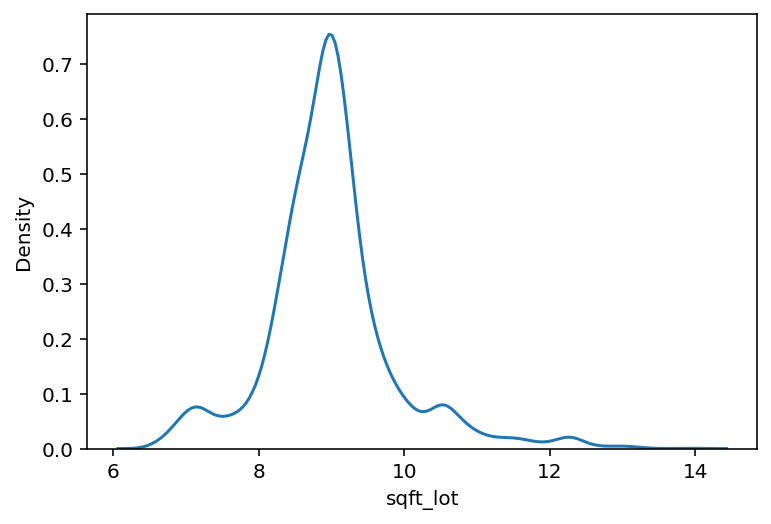

In [28]:
test['sqft_lot'] = np.log1p(test['sqft_lot'])
print(test['sqft_lot'])

sns.kdeplot(test['sqft_lot'])
plt.show()

## C. sqft_above

0        7.074117
1        6.647688
2        7.427144
3        7.447751
4        6.966967
           ...   
15030    7.832411
15031    7.863651
15032    7.333676
15033    7.745436
15034    6.928538
Name: sqft_above, Length: 15035, dtype: float64


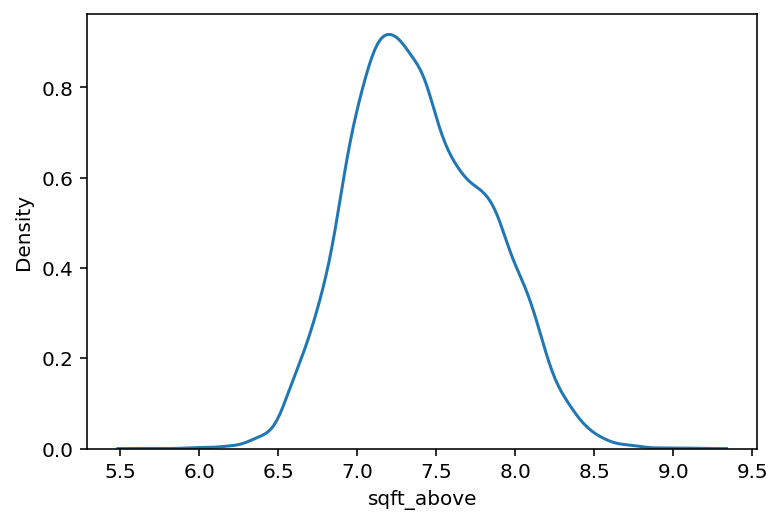

In [29]:
train['sqft_above'] = np.log1p(train['sqft_above'])
print(train['sqft_above'])

sns.kdeplot(train['sqft_above'])
plt.show()

0       7.682943
1       6.957497
2       8.266421
3       6.957497
4       7.544861
          ...   
6463    7.313887
6464    7.307202
6465    7.074117
6466    6.928538
6467    7.378384
Name: sqft_above, Length: 6468, dtype: float64


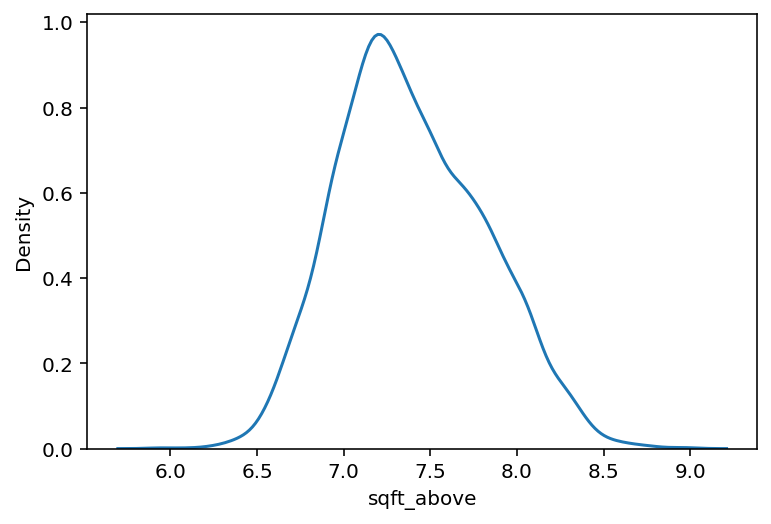

In [30]:
test['sqft_above'] = np.log1p(test['sqft_above'])
print(test['sqft_above'])

sns.kdeplot(test['sqft_above'])
plt.show()

## D. sqft_basement

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
15030    0.000000
15031    6.814543
15032    0.000000
15033    0.000000
15034    0.000000
Name: sqft_basement, Length: 15035, dtype: float64


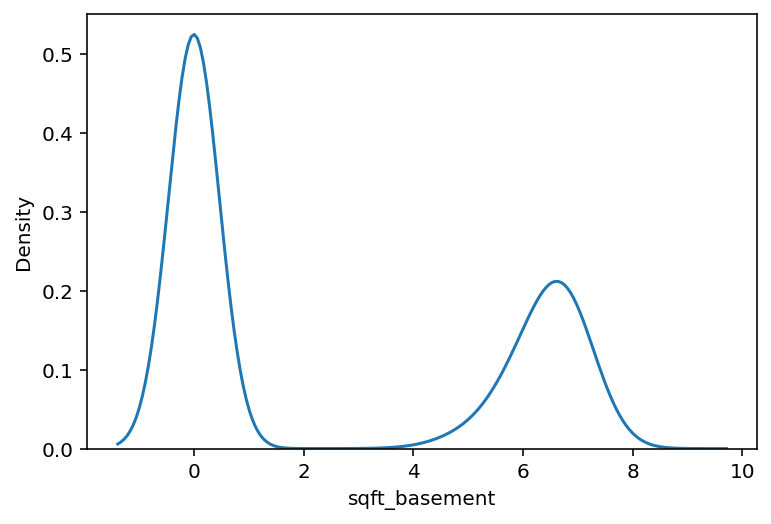

In [31]:
train['sqft_basement'] = np.log1p(train['sqft_basement'])
print(train['sqft_basement'])

sns.kdeplot(train['sqft_basement'])
plt.show()

0       5.993961
1       6.814543
2       7.333676
3       6.594413
4       0.000000
          ...   
6463    0.000000
6464    0.000000
6465    4.875197
6466    0.000000
6467    0.000000
Name: sqft_basement, Length: 6468, dtype: float64


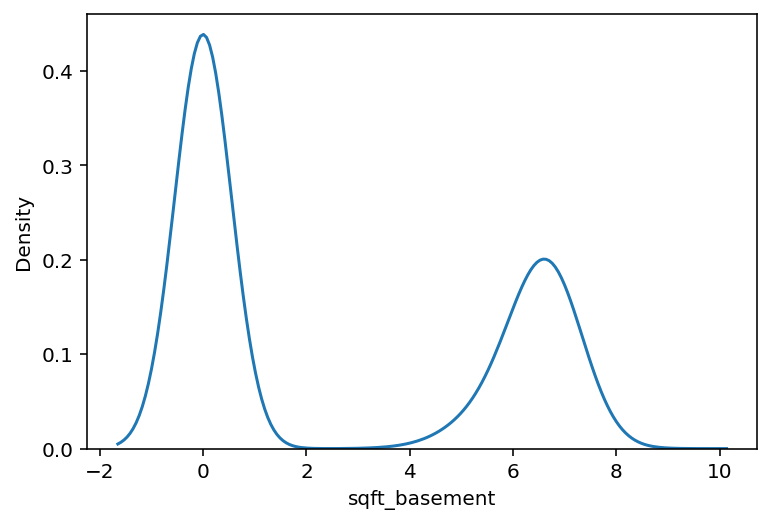

In [32]:
test['sqft_basement'] = np.log1p(test['sqft_basement'])
print(test['sqft_basement'])

sns.kdeplot(test['sqft_basement'])
plt.show()

## E. sqft_living15

0        7.201171
1        7.908755
2        7.496097
3        7.713785
4        7.409136
           ...   
15030    7.832411
15031    7.626083
15032    7.333676
15033    7.512618
15034    6.928538
Name: sqft_living15, Length: 15035, dtype: float64


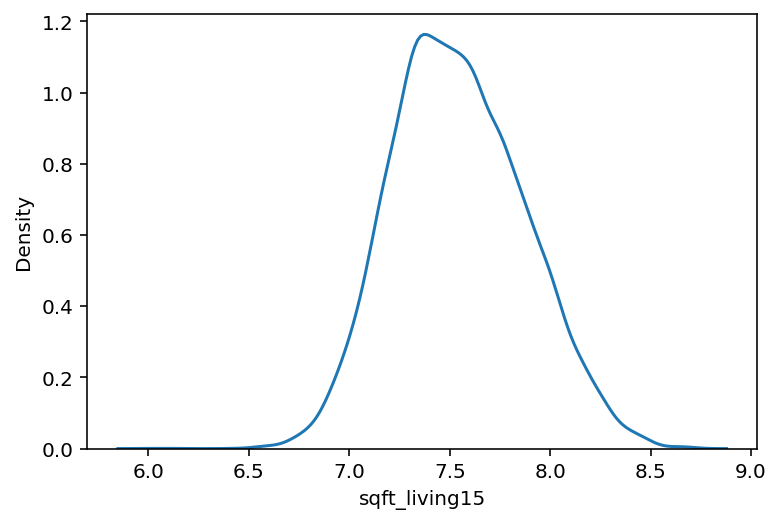

In [33]:
train['sqft_living15'] = np.log1p(train['sqft_living15'])
print(train['sqft_living15'])

sns.kdeplot(train['sqft_living15'])
plt.show()

0       7.433075
1       7.215975
2       8.468213
3       7.484930
4       7.779467
          ...   
6463    7.186144
6464    7.244942
6465    7.193686
6466    6.928538
6467    7.252054
Name: sqft_living15, Length: 6468, dtype: float64


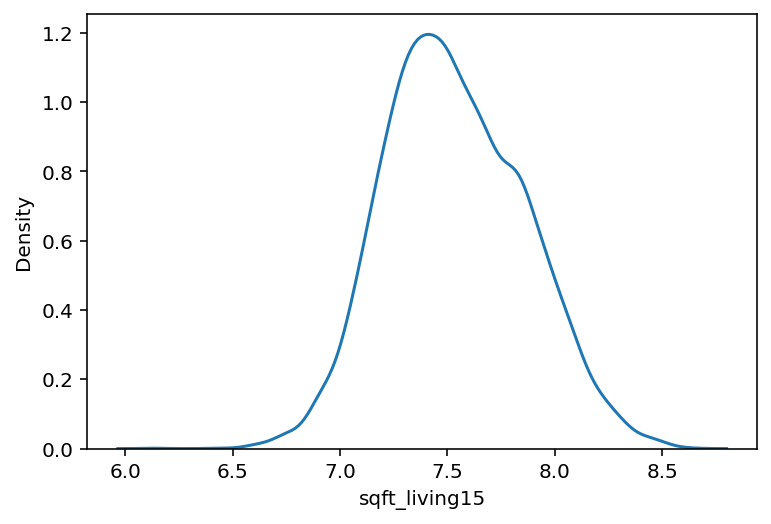

In [34]:
test['sqft_living15'] = np.log1p(test['sqft_living15'])
print(test['sqft_living15'])

sns.kdeplot(test['sqft_living15'])
plt.show()

## F. sqft_lot15

0        8.639588
1        8.995041
2        8.923191
3        8.827615
4        9.181118
           ...   
15030    8.703507
15031    8.732466
15032    7.319865
15033    8.881975
15034    7.213768
Name: sqft_lot15, Length: 15035, dtype: float64


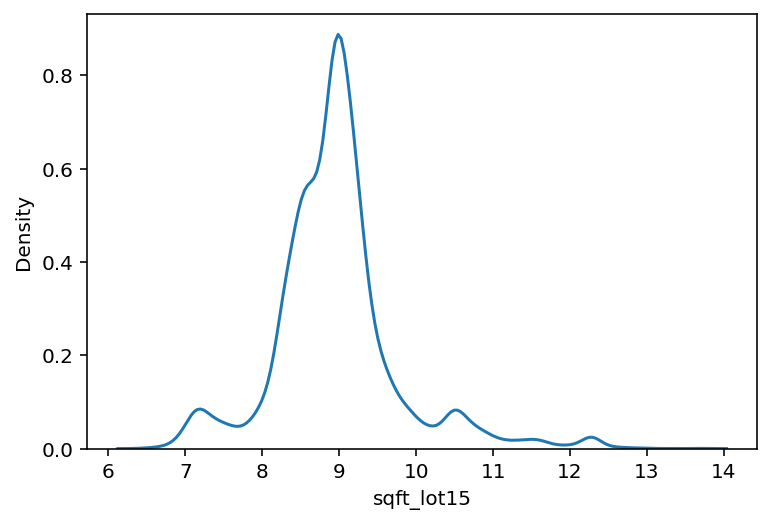

In [35]:
train['sqft_lot15'] = np.log1p(train['sqft_lot15'])
print(train['sqft_lot15'])

sns.kdeplot(train['sqft_lot15'])
plt.show()

0        8.941153
1        8.517393
2       11.532051
3        9.001346
4        8.932080
          ...    
6463     9.332912
6464     7.115582
6465     7.143618
6466     7.604894
6467     7.160846
Name: sqft_lot15, Length: 6468, dtype: float64


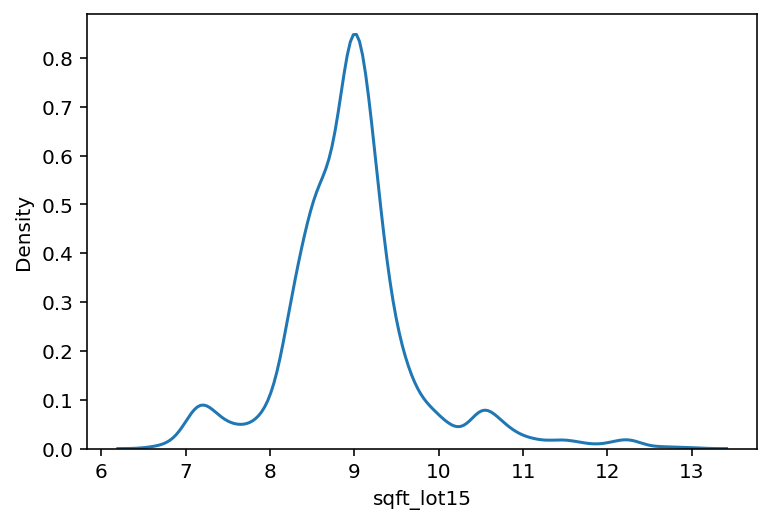

In [36]:
test['sqft_lot15'] = np.log1p(test['sqft_lot15'])
print(test['sqft_lot15'])

sns.kdeplot(test['sqft_lot15'])
plt.show()

- 정규화까지의 작업을 모두 마침으로서 데이터 전처리는 이것으로 마무리하고자 한다.

### ✨ 모델 튜닝하기 ✨
- Exploration 6 노드에서 설명하고 있는 집값 데이터 예측 대회의 평가 척도로 **RMSE**를 사용한다.
- 우선 아래와 같이 RMSE를 구하기 위한 라이브러리를 불러오고 함수를 정의해 보겠다.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE를 계산하기 위해 함수를 미리 정의해 두면 도움이 된다.
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

- 다시 이번 대회의 문제 종류를 상기하면, 이 문제는 집값을 예측하는 **회귀(Regression) 문제**이다.
- 따라서 회귀모델을 사용하는 것이 적합하다.

In [38]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

- 이제 각 모델에 대한 score를 확인해 보고, 데이터프레임으로 출력한다.

In [41]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.15)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,0.185591
RandomForestRegressor,0.181160
XGBRegressor,0.169643
LGBMRegressor,0.167113


### ✨ 그리드 탐색(Grid Search) 활용하기 ✨
#### 그리드 탐색은 하이퍼 파라미터를 조합하는 방법이다.
#### 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색한다.
#### 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 활용한다.
#### 이 과정에서 하게 되는 것들은 다음과 같다.
- A. 필요한 라이브러리 불러오기
- B. 함수 및 인자 세팅하기
- C. 모델 준비 및 fitting, 학습하기
- D. 최종 submission 하기

## A. 필요한 라이브러리 불러오기
- sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용할 것이다.

In [42]:
from sklearn.model_selection import GridSearchCV

## B. 함수 및 인자 세팅하기
#### 1. GridSearchCV에 입력하는 인자들
- **param_grid** : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- **scoring** : 모델의 성능을 평가할 지표
- **cv** : cross validation(교차 검증)을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- **verbose** : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지 출력)
- **n_jobs** : 그리드 탐색을 진행하면서 사용할 CPU의 개수

#### 2. RMSLE
- 회귀에서 평가를 위해 사용되는 지표는 **실제값과 예측값의 차이를 기반**으로 한다.
- RMSLE는 Root Mean Squared Log Error의 약자로, **RMSE 값에 log를 적용한 지표**이다.
- 이 값이 **작을수록 성능이 좋다.**
- RMSLE의 주요 장점으로는 이상치에 강건하고, 실제값과 예측값의 상대적인 Error를 측정해준다는 점을 들 수 있다.

In [43]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델을 활용한다.
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델을 fitting 한다.
    grid_model.fit(train, y)

    # 결과 값을 다른 변수에 저장한다.
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임을 생성한다.
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값을 계산한 다음 sort_values를 이용해 정렬한다.
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

#### 3. param_grid에 탐색할 xgboost 관련 하이퍼 파라미터 준비

In [44]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

lgbm_model = LGBMRegressor(random_state=random_state)
my_GridSearch(lgbm_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    2.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000140,0.011836
2,10,50,-0.000151,0.012278
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019175


## C. 모델 준비 및 fitting, 학습하기
- 우선 평가에 사용할 모델을 준비한다. 이번 프로젝트에서는 **LightGBM**과 **XGBRegressor**를 사용한다.
- train과 y 데이터를 활용하여 모델을 학습시킨다.
- param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실시한다.

In [45]:
lgbm_model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
lgbm_model.fit(train, y)
lgbm_prediction = lgbm_model.predict(test)
lgbm_prediction

array([2.64364262, 2.64014739, 2.71797999, ..., 2.6413381 , 2.61577285,
       2.63572556])

- 이제 log 변환을 실시했던 데이터들을 **np.expm1()**을 써서 원래대로 되돌린다.

In [46]:
lgbm_prediction = np.expm1(lgbm_prediction)
lgbm_prediction

array([13.06434146, 13.01526921, 14.14968879, ..., 13.03196719,
       12.67778315, 12.95343288])

- **XGBRegressor** 모델에게도 같은 방법을 적용하면 된다.

In [49]:
xgb_model = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
xgb_model.fit(train, y)
xgb_prediction = xgb_model.predict(test)
xgb_prediction

array([2.6447465, 2.6411016, 2.7166479, ..., 2.6427624, 2.620641 ,
       2.6353087], dtype=float32)

In [50]:
xgb_prediction = np.expm1(xgb_prediction)
xgb_prediction

array([13.079876 , 13.028649 , 14.129521 , ..., 13.051968 , 12.744531 ,
       12.9476185], dtype=float32)

- 마지막으로 **np.vstack()**을 활용해서 두 예측값에 대한 평균을 넘파이 array로 출력한다.

In [51]:
ensemble_pred = np.vstack([lgbm_prediction, xgb_prediction]).mean(0)
ensemble_pred

array([13.0721087 , 13.02195927, 14.13960508, ..., 13.04196741,
       12.71115691, 12.95052568])

## D. 최종 submission 하기

- 이제 그리드 탐색을 수행한 결과를 바탕으로 submission을 한다.
- submission 데이터프레임의 price에 결과를 모델이 예측한 값에 덮어씌운다.

In [48]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [52]:
submission['price'] = ensemble_pred
submission.head()

,id,price
0,15035,13.072109
1,15036,13.021959
2,15037,14.139605
3,15038,12.710929
4,15039,12.697137


- 마지막 절차이다.
- 아까 sample_submission.csv 파일이 있었던 디렉토리에 모델의 예측값이 적용된 csv 파일을 submission 하면 모든 절차가 완료된다! 🎉🎉

In [53]:
submission.to_csv(join(data_dir,"submission_exp6_ksm.csv"),index=False)

## 👀 프로젝트 회고 👀

- 이번 프로젝트는 Data Science에 있어서 최대의 커뮤니티인 'Kaggle'의 이미 종료된 경진대회에 submission을 하기까지 과정을 체험하는 프로젝트였다.
- 모델의 성능을 끌어올리기 위해 하이퍼 파라미터 튜닝 뿐만 아니라 그리드 탐색 기법을 사용하여 직접 코드로 알아볼 수 있었다.
- 이번 프로젝트에서는 LightGBM과 XGBRegressor 두 개의 회귀 모델에서 도출된 예측값을 평균화한 최종 결과를 마지막 price 데이터에 저장하여 submission으로 제출하였다.
- 차분하게 흐름을 따라가다 보니 캐글에 submission을 제출하기까지의 전 과정을 오류 없이 무사히 마칠 수 있어서 좋았다.
- 데이터 분석을 통해 인사이트를 찾아내는 것이 다양한 과정을 거쳐서 나오는 만큼 쉽지 않은 여정임을 체감할 수 있었다.
- AI의 세계는 굉장히 다양하고 넓다. 꼭 AIFFEL이 아니더라도 계속 열심히 공부해서 처음 입교했을 때보다 발전된 모습을 보여주고 싶다.
- 마지막으로 Kaggle 사이트에서 확인한 Score는.. 처참..했다..ㅠㅠ (60만점 대.. 더 연구하겠습니다ㅠㅠ)

## 🤞 프로젝트 수행 간 참고 자료 🤞

[**회귀 평가 지표 알아보기**] https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-17-%ED%9A%8C%EA%B7%80-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C

## 😢 프로젝트 score 😢

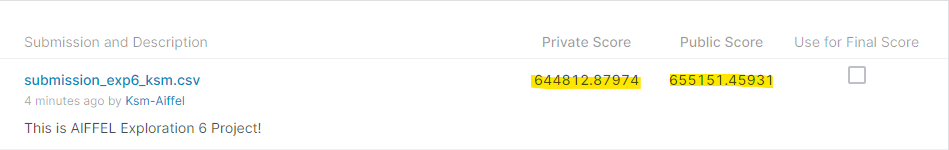